In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastai.vision.all import *
from fastbook import *

matplotlib.rc("image", cmap="Greys")

## Under the Hood: Training a Digit Classifier
- examine the roles of arrays and tensors
- explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically
- discuss the choice of loss function for basic classification

- we will use MNIST a famous dataset of handwritten digits

In [4]:
# download MNIST sample
path = untar_data(URLs.MNIST_SAMPLE)

In [5]:
Path.BASE_PATH = path

In [6]:
# show the directory
path.ls()

# inside the training set is a 3s and 7s directory
(path/"train").ls()

# 3s and 7s are the labels or targets in this dataset

threes = (path/"train"/"3").ls().sorted()
sevens = (path/"train"/"7").ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
# Image class from Python Imaging Library (PIL). Used to open, view and manipulate images
im3 = Image.open(im3_path)
im3

In [8]:
# In a computer everything is a number
# To view the numbers that make up this image convert it to a NumPy or PyTorch tensor
# view a section as a NumPy array
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
# as a tensor
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
# slice the array to pick the part with the top of the digit
# use Pandas DataFrame to color code the values using a gradient
# show how the image is created from pixel values

im3_t = tensor(im3)
data_frame = pd.DataFrame(im3_t[4:15, 4:22])
data_frame.style.set_properties(**{"font-size": "6pt"}).background_gradient("Greys")

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


In [11]:
# white pixels stored as 0, black as 255, shades of grey in between

How to create a model that can recognize 3s and 7s?

### Pixel Similarity
- find the average pixel value for every pixel of 3, do the same for 7
- this will give us the average defining the ideal 3 and 7
- classify an image by checking to see which of the two ideal digits the image is most similar to
- seems like a good baseline (simple start)



In [12]:
# get average of pixel values for each of the two groups
# create a tensor of all 3s and 7s stacked together
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)


(6131, 6265)

<AxesSubplot:>

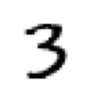

In [13]:
# check that image looks correct
show_image(three_tensors[1])

In [14]:
# combine all images into a single 3d tensor or rank 3 tensor
# use PyTorch stack
# must be a float to do certain operations (ex. mean)

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
# shape shows the length of each axis
stacked_threes.shape

torch.Size([6131, 28, 28])

<AxesSubplot:>

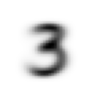

In [15]:
# compute the ideal 3 by calculating the mean of all image tensors
mean3 = stacked_threes.mean(0)
show_image(mean3)

<AxesSubplot:>

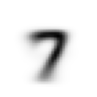

In [16]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

<AxesSubplot:>

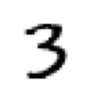

In [17]:
# select an arbitrary 3 and measure its distance from our ideal digit
a_3 = stacked_threes[1]
show_image(a_3)

In [18]:
# we can't add up the differences between pixels of this image and the ideal image
# some may be negative, others positive. If an image is too dark in some and too light in others the result is 0

# instead we could do two things
# take the mean of the absolute value of differences
# take the mean of teh square of differences, then take the square root

# try both
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [19]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [20]:
# our simple model is correct as the distance from 3 is less than the distance from 7
# get the loss, l1 = l1 norm/absolute, mse = mean squared error
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [21]:
# difference between L1 and MSE is the latter will penalize larger mistakes more heavily, more lenient with small mistakes


## NumPy Arrays and PyTorch Tensors
- NumPy widely used library for numeric programming. 
    - similar to PyTorch but does not provide GPU support
    - in this course PyTorch tensors are used over NumPy
- NumPy arrays and PyTorch tensors can finish computations many thousand times faster than using Python
    - wrappers around C
- NumPy array is a multidimensional table of data with items of the same type
- PyTorch tensor is nearly the same but with additional restriction that unlocks capabilities
    - tensor cannot just use any type, it has to be a single basic numeric type for all components
    - can not be jagged or contain different sized arrays within the tensor
- Major benefit of PyTorch tensors is the structures can live on the GPU

In [22]:
data = [[1, 2, 3], [4, 5, 6]]
# numpy
arr = array (data)
# pytorch
tns = tensor (data)

arr, tns

(array([[1, 2, 3],
        [4, 5, 6]]),
 tensor([[1, 2, 3],
         [4, 5, 6]]))

## Computing Metrics Using Broadcasting
- to get a validation set we remove some of the data from training entirely
- MNIST dataset already done for us, valid directory

In [25]:
# create tensors for 3s and 7s in that directory
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"3").ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/"valid"/"7").ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [26]:
# want to write a function is_3 to decide if an image is a 3 or 7
# we do this by deciding which of our two ideal digits is closer
# need to define the notion of distance between two images
def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [27]:
# we need to calculate this distance for every image in the validation set
# passing a tensor to an argument meant for a single image will automatically create a tensor of calculations
# also called broadcasting
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1270, 0.1632, 0.1676,  ..., 0.1228, 0.1210, 0.1287]),
 torch.Size([1010]))

In [28]:
# during broadcasting PyTorch doesn't copy mean3 1010 times. It pretends it were a tensor of that shape, but doesn't allocate the memory
# The whole calculation is done in C (or if using a GPU, CUDA (c on the GPU))

# use mnist_distance to figure out whether an image is a 3 or not by using the logic
# distance between the digit, and if the ideal 3 is less than the idea 7 its a 3. If not 7
def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [29]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [30]:
# brodcast to get all the answers
is_3(valid_3_tens)

tensor([ True, False, False,  ...,  True,  True, False])

In [32]:
# calculate the accuracy for each of the 3s and 7s 
# by taking the average of that function for all 3s and its inverse for all 7s
accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

In [33]:
# getting over 90 percent accuracy on both 3s and 7s
# we need to do better and for more digits
# build a system that does real learning and modify itself to improve (SGD)

## Stochastic Gradient Descent (SGD)
- look at each individual pixel and come up with a set of weights for each
- the higher weights are associated with pixels most likely to be black for a particular category
- this is represented as a function and set of weight values for each possible cateogry
- ex. def pr_eight(x,w): return (x*w).sum()
    - x is the image as a vector
    - w is the weights as a vector
- we want the specific values w that causes the result of our function to have the least amount of loss

### Process
- initialize weights
- for each image, use these weights to predict a 3 or 7
- based on predictions calculate the loss
- calculate the gradient for each weight or how changing the weight would change the loss
- step/change all the weights based on that calculation
- go back to step 2
- iterate until you decide to stop the training process (model is good enough)

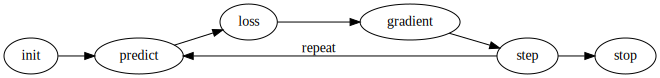

In [34]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

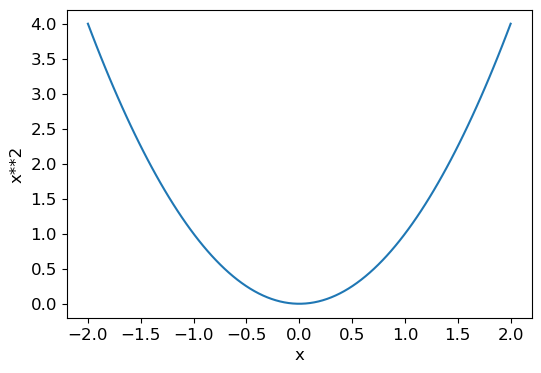

In [35]:
# illustrate a simple example for a quadratic function
def f(x): return x**2
plot_function(f, "x", "x**2")

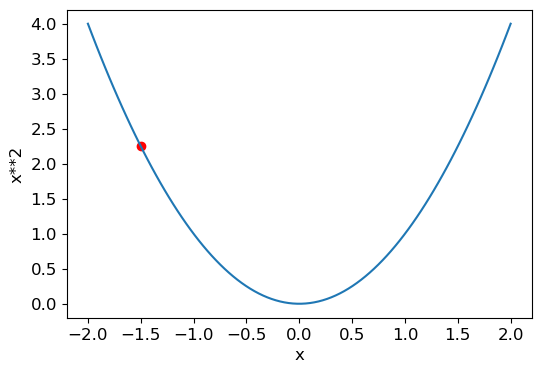

In [37]:
# pick random values to initialize the "weights"
plot_function(f, "x", "x**2")
plt.scatter(-1.5, f(-1.5), color="red")

# next we would see what would happened if we increased or decreased our parameter by a bit (adjustment)
# This is the slope at the particular point
# We change our weight by a little in the direction of the slope, calculate the loss and adjust again
# eventually we get to the lowest point on the curve

## Calculating Gradients
- using derivatives we can determine how rapdily something will change
- gradient is defined as rise/run, change in value of the function divided in change of the value of the parameter
- PyTorch can do the heavy lifting of calculating these values

In [42]:
# pick a tensor value which we want gradients at
# requires_grad_ tells PyTorch we want to calculate gradients with respect to that variable at that value
xt = tensor(3.).requires_grad_()
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [43]:
# calculate the gradients with backpropagation (calculating the derivative at each layer)
yt.backward()

In [46]:
# view the gradients
xt.grad
# derivative of x**2 is 2*x, when x is 3 the derivative is 2*3=6

tensor(6.)

In [47]:
# do the same but with a vector argument
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [48]:
def f(x): return(x**2).sum()
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [49]:
# gradients are 2*xt as expected
yt.backward()
xt.grad
# gradients only tell us slope, not how far to adjust, but gives us an idea of how far

tensor([ 6.,  8., 20.])

## Stepping with a Learning Rate
- at each step we multiply the gradient by some small number (learning rate)
- learning rate is often between 0.001 and 0.1, although it could be anything
- learning rate often just chosen by training a few and finding the best result

- w -= gradient(w) * lr

- this is stepping your parameters using an optimizer step
- we adjust the parameter in the direction of the slope
- the goal is to minimize the loss
- picking too low of a learning rate means a lot more steps
- picking too high can overshoot 

In [50]:
# End to End SGD Example
# imagine you were measuring the speed of a roller coaster as it went over the top of a hump
# you want to build a model of how speed changes over time
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

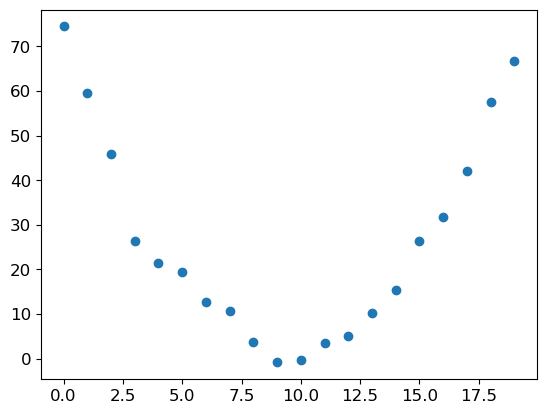

In [51]:
# add random noise
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)


In [52]:
# first we try to find a function that matches our observation
# try quadratic a*(time**2) + (b*time) + c
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c
# a, b, and c are the weights

In [53]:
# define a loss function
# returns value based on prediction and target
# use mean squared error
def mse(preds, targets):
    return ((preds-targets)**2).mean()

In [56]:
# Step 1: Initialize the parameters
# initialize to random values and tell PyTorch to track the gradients
params = torch.randn(3).requires_grad_()

#keep track of original params
orig_params = params.clone()

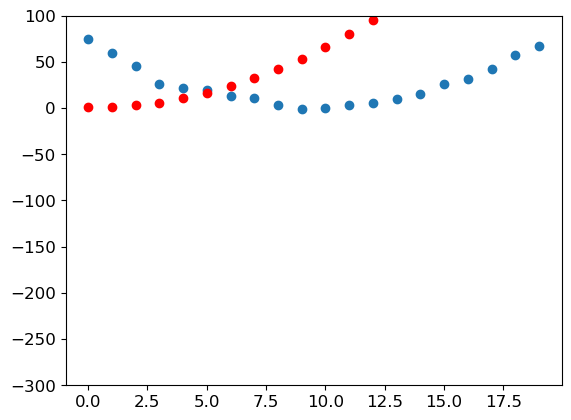

In [58]:
# Step 2: Calculate the predictions
preds = f(time, params)

def show_preds(preds, ax=None):
    if ax is None: 
        ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color="red")
    ax.set_ylim(-300,100)

show_preds(preds)

In [59]:
# Step 3: Calculate the loss
loss = mse(preds, speed)
loss

tensor(8631.7373, grad_fn=<MeanBackward0>)

In [60]:
# Step 4: Calculate the gradients
loss.backward()
params.grad

tensor([29901.0918,  1916.4382,   111.7121])

In [61]:
# use 1e-5 as learning rate
params.grad * 1e-5
params

tensor([ 0.6863, -0.3278,  0.7950], requires_grad=True)

In [62]:
# Step 5: Step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [63]:
# check if loss has improved
preds = f(time, params)
mse(preds, speed)

tensor(2190.2759, grad_fn=<MeanBackward0>)

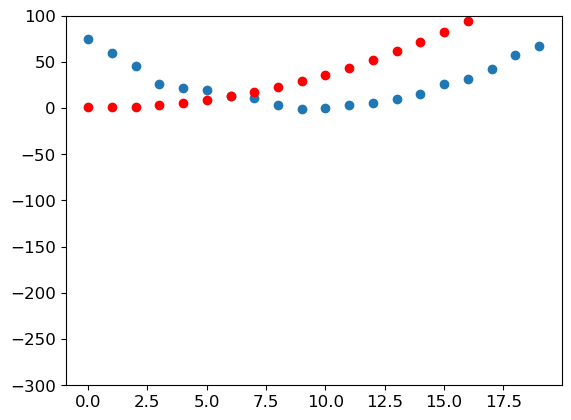

In [64]:
# Getting better
show_preds(preds)

In [65]:
# repeat a few times, create a function to do this for us

def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: 
        print(loss.item())
    return preds

In [66]:
for i in range(10):
    apply_step(params)

2190.27587890625
971.3508911132812
740.6900634765625
697.038818359375
688.775390625
687.2086181640625
686.9088134765625
686.8489990234375
686.8345947265625
686.8284912109375


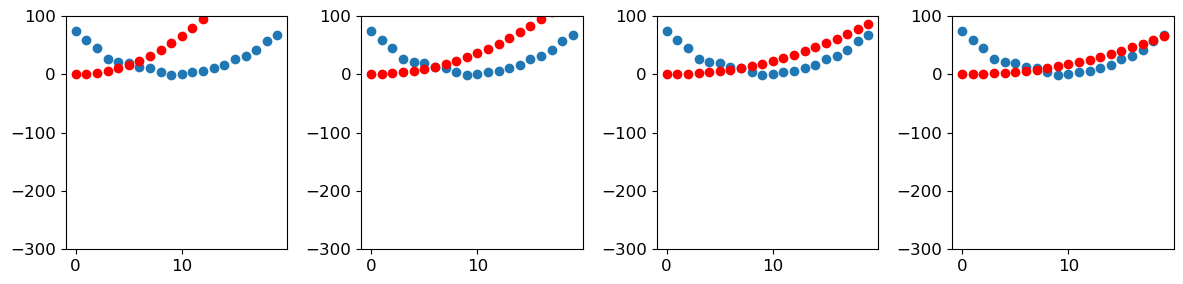

In [69]:
# see how things have changed starting with first params selected
params = orig_params.detach().requires_grad_()

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

In [ ]:
# Step 7: stop
# arbitrarily stopping at 10 epochs (steps)
# in practice we would watch training and validation losses and our metrics to decide when to stop

## The MNIST Loss Function
- 